In [1]:
import os
import csv
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import ResNet18_Weights
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [2]:
data_dir = 'data'
num_classes = 2
batch_size = 32
num_epochs = 20
learning_rate = 0.001
log_file = 'logs/training_log.csv'
model_path = 'models/resnet_best.pth'
label_list = ['notumor', 'glioma', 'meningioma', 'pituitary']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CUDA availabe: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU model: {torch.cuda.get_device_name(0)}")

Using device: cuda
CUDA availabe: True
CUDA version: 12.8
GPU model: NVIDIA GeForce RTX 5060 Ti


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# load Training data
full_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transform)
labels = [sample[1] for sample in full_dataset.samples]

# split train_dataset & val_dataset from Training data
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_idx, val_idx in splitter.split(np.zeros(len(labels)), labels):
    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(full_dataset, val_idx)

# load Testing data
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Testing'), transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

In [4]:
def plot_class_distribution(all_labels, dataset_name):
    label_list = ['0_notumor', '1_glioma', '2_meningioma', '3_pituitary']
    class_counts = np.bincount(all_labels, minlength=num_classes)
    plt.figure(figsize=(8, 6))
    plt.bar(label_list, class_counts, color=['navy', 'green', 'orange', 'brown'])
    plt.xlabel('Class')
    plt.ylim(0,1500)
    plt.ylabel('Number of samples')
    plt.title(dataset_name+' Class Distribution')
    #plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('data/'+dataset_name+' distribution.jpg')
    plt.show()

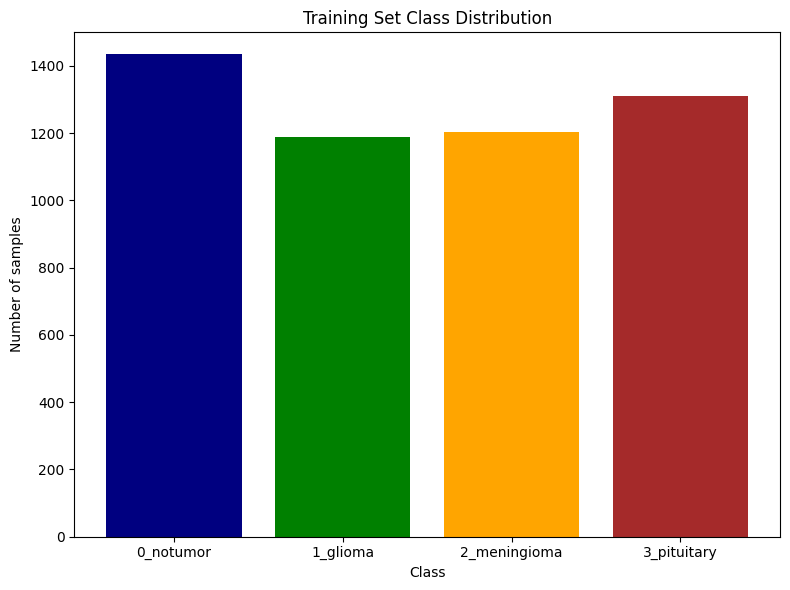

In [5]:
plot_class_distribution(np.array(full_dataset.targets)[train_dataset.indices], 'Training Set')

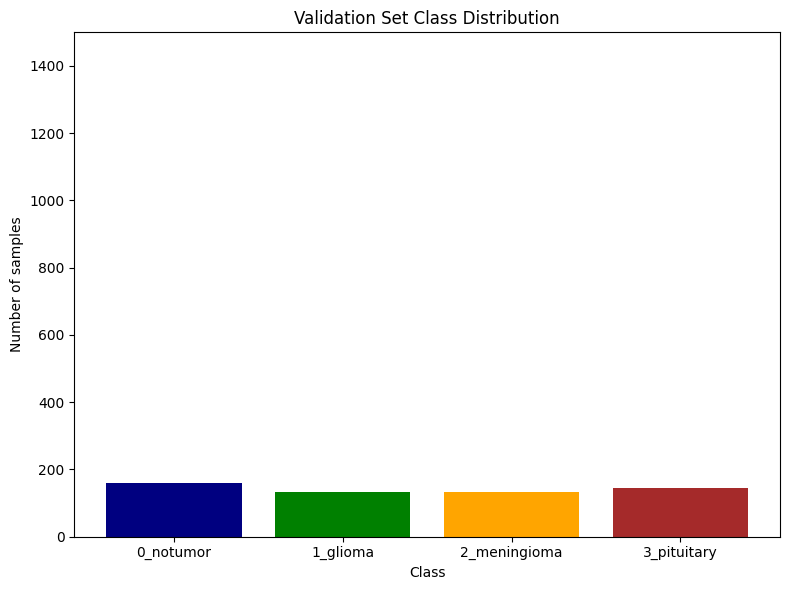

In [6]:
plot_class_distribution(np.array(full_dataset.targets)[val_dataset.indices], 'Validation Set')

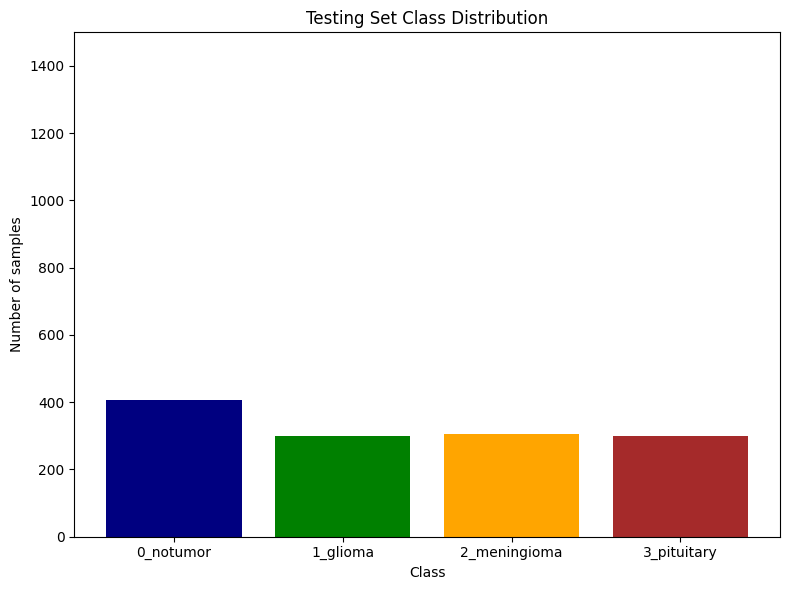

In [7]:
plot_class_distribution(np.array(test_dataset.targets), 'Testing Set')

In [8]:
# training
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# build up log
os.makedirs("models", exist_ok=True)
with open(log_file, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'train_acc', 'val_acc'])

best_val_acc = 0.0

In [9]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    loop = tqdm((train_loader), total = len(train_loader))
    
    for images, labels in loop:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.detach().item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        train_loss = running_loss / len(train_dataset)
        train_acc = correct / len(train_dataset)
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss = train_loss, acc = train_acc)
    

    # validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()
    val_acc = correct / len(val_dataset)

    # adjust learning rate
    scheduler.step(val_acc)

    # save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_path)

    # save training log
    with open(log_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, train_loss, train_acc, val_acc])

Epoch [20/20]: 100%|█████████████████████████| 161/161 [00:36<00:00,  4.35it/s, acc=1, loss=0.000191]


In [16]:
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        outputs = model(images)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds)
        all_labels.extend(labels)

report = classification_report(all_labels, all_preds, target_names=full_dataset.classes, output_dict=True)
print("\nTesting report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))
import pandas as pd
df = pd.DataFrame(report).transpose()
df.to_csv("results/testing report.csv")



Testing report:
              precision    recall  f1-score   support

   0_notumor       0.99      1.00      1.00       405
    1_glioma       1.00      0.99      0.99       300
2_meningioma       0.98      0.97      0.98       306
 3_pituitary       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



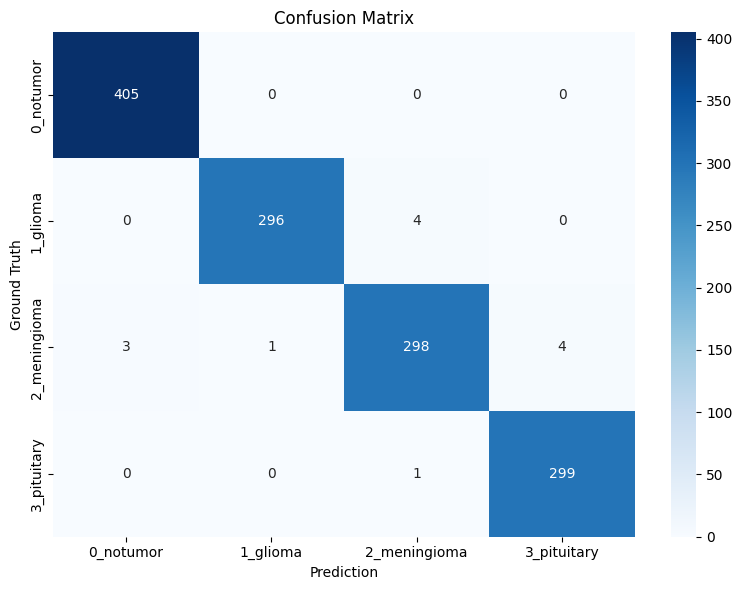

In [17]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('results/confusion_matrix.jpg')
plt.show()